Run with bilomics_env

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from tqdm import tqdm
import dill
import scipy
import matplotlib.pyplot as plt
import math
import seaborn as sns
import importlib
from tqdm import tqdm
from adjustText import adjust_text
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

np.random.seed(0)

paper_path = os.path.dirname(os.getcwd())#"/mnt/x/Common/Lab_Papers/shedding_potential/"

fig4_path = paper_path + "/fig4/"
utils_path = paper_path + "/utils/"
#rev_path = paper_path+"/Submission folder/MSB/Revision/"
cfrna_edf_path = paper_path + "/ev_cfrna/"
os.chdir(utils_path)
print(os.getcwd())
import shed_funcs



LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = utils_path+'/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

    print("scanpy " + str(sc.__version__))
    print("pandas " + str(pd.__version__))
    print("numpy " + str(np.__version__))
    print("scipy " + str(scipy.__version__))

x:\Common\Lab_Papers\shedding_potential\zenodo\utils
scanpy 1.10.2
pandas 1.5.2
numpy 1.26.4
scipy 1.13.1


# Shed Cells paper revision

In [2]:
cfrna_path = paper_path+"/external_datasets/nafld_cfrna_chalasani_2021/"
print("cfRNA data (Chalasani 2021): ", cfrna_path)

cfRNA data (Chalasani 2021):  x:\Common\Lab_Papers\shedding_potential\zenodo/external_datasets/nafld_cfrna_chalasani_2021/


## Load tabula sapiens epithelial compartment organs signature table

In [3]:
ts_organs_path = paper_path+"/external_datasets/TabulaSapiens_epithelium_organs_signature_matrix.csv"
ts_organs = pd.read_csv(ts_organs_path, index_col=0)
ts_organs.head(2)

,Liver,Trachea,Blood,Lymph_Node,Salivary_Gland,Spleen,Tongue,Mammary,Uterus,Eye,...,Pancreas,Prostate,Muscle,Thymus,Bladder,Large_Intestine,Lung,Small_Intestine,Vasculature,Kidney
DDX11L1,1.687035e-07,6.817481e-08,9.828013e-07,8.776327e-08,0.000000,1.039137e-07,3.274722e-07,8.079657e-08,5.986599e-07,2.827963e-07,...,0.000000,7.889242e-07,5.123729e-07,8.491958e-08,6.523513e-08,0.000000,2.077968e-07,4.403774e-07,0.000000,3.117350e-08
WASH7P,3.065767e-06,3.526514e-06,7.736416e-06,3.134083e-06,0.000001,6.032810e-06,4.728186e-06,4.122982e-07,1.681123e-06,1.366256e-06,...,0.000004,2.313073e-06,5.660166e-06,1.549642e-06,4.932902e-06,0.000009,3.520482e-06,8.214438e-06,0.000008,2.161740e-06


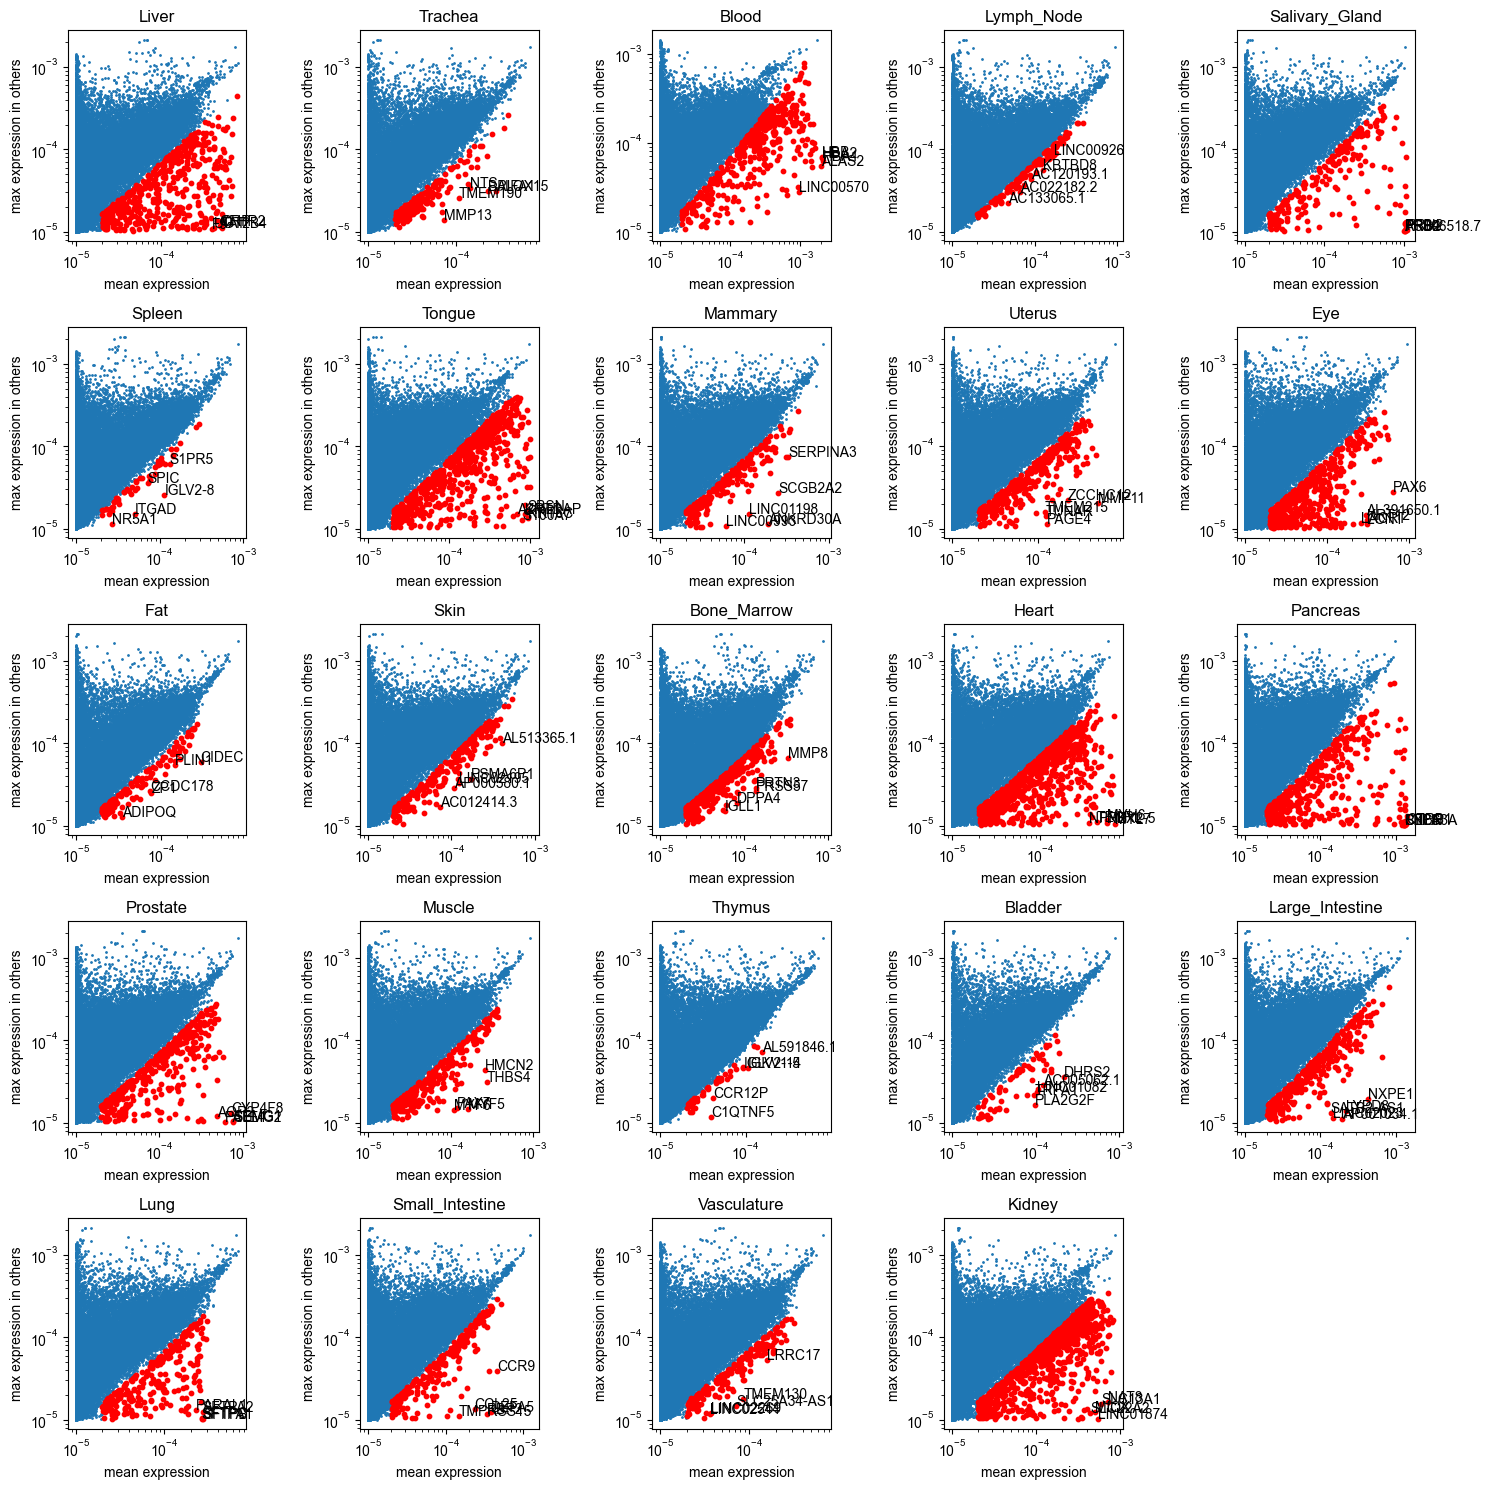

In [4]:
[_, organs_markers_dict] = shed_funcs.identify_marker_genes(ts_organs, min_exp=1e-5, min_fc=1.5, pn=1e-5)

In [5]:
print("# of large intestine markers: " + str(len(organs_markers_dict['Large_Intestine'])))

# of large intestine markers: 333


## Load and preprocess Chalasani 2021

In [6]:
CREATE_FROM_SCRATCH = False
exp_path_str = cfrna_path+"adata.dill"

if CREATE_FROM_SCRATCH:
    metadata = pd.read_excel(cfrna_path+"NAFLD Clinical information.xltx")
    metadata = metadata.set_index("Library Name")
    raw_umi_tbl = pd.read_csv(cfrna_path+"TPM_Narrow.csv")

    samples = raw_umi_tbl.Prefix.unique()
    genes = raw_umi_tbl.Description.unique()

    # create empty AnnData object
    adata = sc.AnnData(X=np.zeros((len(samples), len(genes))), obs=samples, var=genes)
    adata.obs.columns = ['sample']
    adata.obs.set_index('sample', inplace=True)
    adata.var.columns = ['gene_name']
    adata.var.set_index('gene_name', inplace=True)

    # remove duplicated rows from metadata
    metadata = metadata.loc[~metadata.index.duplicated(keep='first')]
    # add metadata to adata.obs
    adata.obs = adata.obs.join(metadata, how='left')

    # fill the AnnData object with the TPM values
    for my_sample in tqdm(adata.obs.index):
        sample_umi_tbl = raw_umi_tbl.loc[raw_umi_tbl.Prefix == my_sample, ['Description', 'TPM']]
        sample_umi_tbl = sample_umi_tbl.dropna(subset=['Description'])
        adata[my_sample, sample_umi_tbl.Description] = sample_umi_tbl.TPM.values

    # save anndata using dill
    with open(exp_path_str, 'wb') as file:
        dill.dump(adata, file)

# Compare wash and cfRNA expression

In [7]:
# load adata using dill
with open(exp_path_str, 'rb') as file:
    cfrna_ad = dill.load(file)
cfrna_ad.var_names = cfrna_ad.var_names.astype(str)
cfrna_ad

AnnData object with n_obs × n_vars = 597 × 36125
    obs: 'Run', 'AGE', 'Assay Type', 'AvgSpotLen', 'Bases', 'BIOMATERIAL_PROVIDER', 'BioProject', 'BioSample', 'BioSampleModel', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'disease', 'disease_stage', 'Experiment', 'Instrument', 'isolate', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sample_type', 'sex', 'SRA Study', 'tissue'

In [8]:
cfrna_ad = cfrna_ad[cfrna_ad.obs.disease.str.lower() == "healthy"]
cfrna_ad.obs.head(2)

,Run,AGE,Assay Type,AvgSpotLen,Bases,BIOMATERIAL_PROVIDER,BioProject,BioSample,BioSampleModel,Bytes,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,sample_type,sex,SRA Study,tissue
sample,,,,,,,,,,,,,,,,,,,,,
12687-A1,SRR13991039,55.0,RNA-Seq,151.0,1.035858e+09,"Molecular Stethoscope Inc\, 3210 Merryfield Ro...",PRJNA701722,SAMN17905440,Human,409574573.0,...,Homo sapiens,ILLUMINA,2021-03-17T00:00:00Z,2021-03-17T19:58:00Z,1.0,12687-A1,serum,male,SRP308394,Serum
12687-A2,SRR13990996,55.0,RNA-Seq,151.0,5.571113e+08,"Molecular Stethoscope Inc\, 3210 Merryfield Ro...",PRJNA701722,SAMN17905441,Human,206713687.0,...,Homo sapiens,ILLUMINA,2021-03-17T00:00:00Z,2021-03-17T19:46:00Z,1.0,12687-A2,serum,male,SRP308394,Serum


In [9]:
UMI_THRESH = 10000

t = scipy.io.loadmat(fig4_path+'data_dan_paper.mat')
t = t['t']

sdata = sc.AnnData(np.array(t['seq_data'][0][0]).T)
sdata.var.index = [gene[0][0] for gene in pd.DataFrame(t['gene_name'])[0][0]]
sdata.obs.index = [pt[0][0] for pt in pd.DataFrame(t['Sample_name'])[0][0].tolist()]

field_to_add = ["Location","Patient","Disease_str","Sample_type"]
for field in field_to_add:
    sdata.obs[field] = [x[0] for x in pd.DataFrame(t[field])[0][0]]

additional_round = ['Location', 'Disease_str',"Sample_type"]
for field in additional_round:
    sdata.obs[field] = [x[0] for x in sdata.obs[field]]

sdata.obs.index.name="sample_name"
sdata.var.index.name="gene_name"
sdata.var['gene_name'] = sdata.var.index
sdata.obs.columns = sdata.obs.columns.str.lower()
sdata.obs.sample_type = sdata.obs.sample_type.str.lower()
print(sdata.shape)
sdata.obs.head()

print(sdata.shape)
specific_genes_to_remove = ["MTRNR2L12", "MTRNR2L1", "MTRNR2L8"]#], "AURKAIP1", "GPM6A"]
filter_genes = sdata.var_names.str.startswith("MT-") + sdata.var_names.isin(specific_genes_to_remove) + sdata.var_names.str.contains("RPL") + sdata.var_names.str.contains("RPS")
sdata = sdata[:,~filter_genes]
print(sdata.shape)

# calculate sum of counts per cell
sdata.obs['sum_of_umis'] = 0
sdata.obs.sum_of_umis = np.sum(sdata.X,axis=1)

# filter samples wiht sum_of_umis < UMI_THRESH
print(sdata.shape)
sdata = sdata[sdata.obs.sum_of_umis > UMI_THRESH,:]
print(sdata.shape)
sdata_hc = sdata[(sdata.obs.disease_str == "control") * (sdata.obs.location.isin(["R","L"]))].copy()
print(sdata.shape)


(278, 18924)
(278, 18924)
(278, 18743)
(278, 18743)
(250, 18743)
(250, 18743)


C:\Users\talbarka.WISMAIN\AppData\Local\Temp\ipykernel_29704\1990772045.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.obs['sum_of_umis'] = 0


In [10]:
# Ensure both var_names are strings before intersection
intersect_genes = np.intersect1d(cfrna_ad.var_names, sdata_hc.var_names)
print("intersect genes: ", len(intersect_genes))

intersect genes:  17830


In [11]:
sdata_hc = sdata_hc[:, intersect_genes].copy()
print(sdata_hc.shape)
cfrna_ad = cfrna_ad[:, intersect_genes].copy()
print(cfrna_ad.shape)

# join two annDatas
li_adata = cfrna_ad.concatenate(sdata_hc, join='outer', index_unique=None)
li_adata

(101, 17830)
(45, 17830)


C:\Users\talbarka.WISMAIN\AppData\Local\Temp\ipykernel_29704\126596698.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  li_adata = cfrna_ad.concatenate(sdata_hc, join='outer', index_unique=None)


AnnData object with n_obs × n_vars = 146 × 17830
    obs: 'Run', 'AGE', 'Assay Type', 'AvgSpotLen', 'Bases', 'BIOMATERIAL_PROVIDER', 'BioProject', 'BioSample', 'BioSampleModel', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'disease', 'disease_stage', 'Experiment', 'Instrument', 'isolate', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sample_type', 'sex', 'SRA Study', 'tissue', 'location', 'patient', 'disease_str', 'sum_of_umis', 'batch'
    var: 'gene_name-1'

In [12]:
li_adata.obs.sample_type.value_counts()

wash      51
biopsy    50
serum     45
Name: sample_type, dtype: int64

(146, 17830)
Correlation: 0.46700833921725426, p-value: 0.0


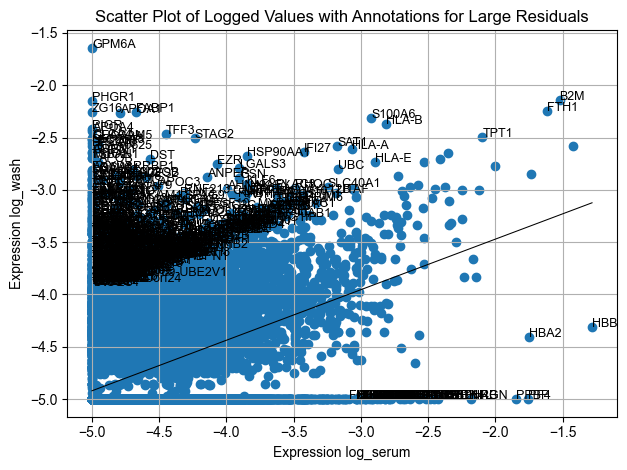

Correlation: 0.7213030045573933, p-value: 0.0


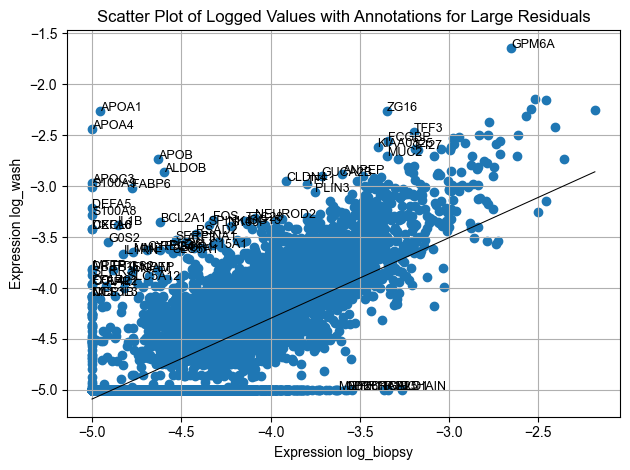

Correlation: 0.6411264996687894, p-value: 0.0


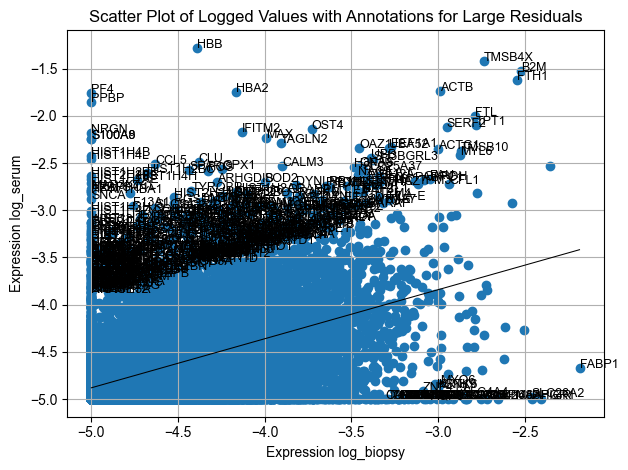

In [13]:
li_adata.layers['counts'] = li_adata.X.copy()
li_adata.layers['mat_norm'] = sc.pp.normalize_total(li_adata, target_sum=1, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X']
li_adata.layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(li_adata, target_sum=10000, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X'], copy=True)
li_adata.layers['log_zscore'] = li_adata.layers['log_norm'].copy()

importlib.reload(shed_funcs)
# select controls and RL colon
print(li_adata.shape)

resids_hc = shed_funcs.calc_resids_by_field(li_adata, "sample_type", "serum", "wash", RESID_THRESH=1, layer='mat_norm')
resids_hc['gene_display'] = resids_hc.index

my_PN = 1e-5
resids_hc_biopsy_wash = shed_funcs.calc_resids_by_field(li_adata, "sample_type", "biopsy", "wash", RESID_THRESH=1, layer='mat_norm', PN=my_PN)
resids_hc_biopsy_wash['gene_display'] = resids_hc_biopsy_wash.index
resids_hc_biopsy_serum = shed_funcs.calc_resids_by_field(li_adata, "sample_type", "biopsy", "serum", RESID_THRESH=1, layer='mat_norm', PN=my_PN)
resids_hc_biopsy_serum['gene_display'] = resids_hc_biopsy_serum.index

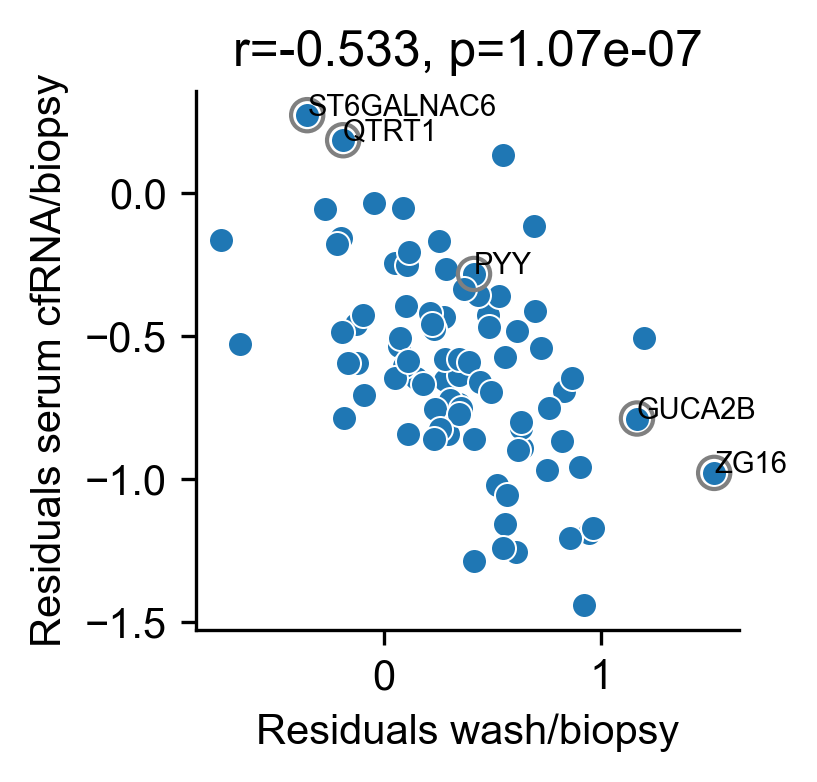

In [49]:
# correlation between residuals of non-zero genes both in wash and serum
fig,ax = plt.subplots(figsize=(7/3, 7/3), dpi=300)
df_resids_wash_serum = pd.merge(resids_hc_biopsy_wash, resids_hc_biopsy_serum, how='inner', suffixes=('_biopsy_wash', '_biopsy_serum'), left_on='gene_display', right_on='gene_display')
df_resids_wash_serum.index = df_resids_wash_serum.gene_display

gene_mask = df_resids_wash_serum.gene_display.isin(np.intersect1d(df_resids_wash_serum.gene_display, organs_markers_dict['Large_Intestine']))
# filter genes that are zero in both wash and serum
expressed_genes = df_resids_wash_serum.index[df_resids_wash_serum.loc[:,['log_wash','log_serum']].sum(axis=1) == 2*np.log10(my_PN)].values
gene_mask[expressed_genes] = False

sns.scatterplot(data=df_resids_wash_serum.loc[gene_mask], x='residual_biopsy_wash', y='residual_biopsy_serum')
# add selceted genes as text labels
texts = ['ZG16','GUCA2B',"QTRT1","PYY","ST6GALNAC6"]
for i, row in df_resids_wash_serum.loc[gene_mask].iterrows():
    if row['gene_display'] in texts:
        plt.text(row['residual_biopsy_wash'], row['residual_biopsy_serum'], row['gene_display'], fontsize=7, )
        # add a circle around the original point using scatter with empty markers
        plt.scatter(row['residual_biopsy_wash'], row['residual_biopsy_serum'], facecolors='none', edgecolors='gray', s=60, linewidth=1)
[r, p] = scipy.stats.spearmanr(df_resids_wash_serum.loc[gene_mask].residual_biopsy_wash, df_resids_wash_serum.loc[gene_mask].residual_biopsy_serum)
plt.title("r=" + f"{r:.3f}" + ", p=" + f"{p:.2e}")
plt.xlabel("Residuals wash/biopsy")
plt.ylabel("Residuals serum cfRNA/biopsy")
sns.despine()
plt.show()
fig.savefig(cfrna_edf_path+"resids_wash_cfRNA.pdf",bbox_inches='tight', dpi=300)

In [46]:
# import plotly.express as px
# px.scatter(df_resids_wash_serum.loc[gene_mask], x='residual_biopsy_wash', y='residual_biopsy_serum',
#            hover_name='gene_display',)

In [16]:
df_resids_wash_serum

,biopsy_biopsy_wash,wash,log_biopsy_biopsy_wash,log_wash,residual_biopsy_wash,gene_display,biopsy_biopsy_serum,serum,log_biopsy_biopsy_serum,log_serum,residual_biopsy_serum
gene_display,,,,,,,,,,,
A1BG,0.000014,0.000000,-4.622354,-5.000000,-0.209276,A1BG,0.000014,0.000033,-4.622354,-4.370367,0.314533
A1CF,0.000113,0.000117,-3.911543,-3.897598,0.330391,A1CF,0.000113,0.000002,-3.911543,-4.919589,-0.603804
A2M,0.000062,0.000000,-4.143934,-5.000000,-0.588032,A2M,0.000062,0.000037,-4.143934,-4.324545,0.111917
A2ML1,0.000000,0.000000,-5.000000,-5.000000,0.089698,A2ML1,0.000000,0.000000,-5.000000,-5.000000,-0.118994
A3GALT2,0.000000,0.000000,-5.000000,-5.000000,0.089698,A3GALT2,0.000000,0.000000,-5.000000,-5.000000,-0.118994
...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.000000,0.000000,-5.000000,-5.000000,0.089698,ZYG11A,0.000000,0.000000,-5.000000,-5.000000,-0.118994
ZYG11B,0.000081,0.000039,-4.039001,-4.311014,0.017880,ZYG11B,0.000081,0.000007,-4.039001,-4.763944,-0.381973
ZYX,0.000010,0.000021,-4.708432,-4.509747,0.349123,ZYX,0.000010,0.000873,-4.708432,-3.054066,1.675533


In [17]:
gi_colon_epi_control_path = fig4_path +"pan_gi_colon_epithelial_control.h5ad"
hgca_ad = sc.read(gi_colon_epi_control_path)
hgca_ad

AnnData object with n_obs × n_vars = 102822 × 18442
    obs: 'sampleID', 'level_1_annot', 'level_2_annot', 'level_3_annot', 'n_counts', 'cell_type_ontology_term_id', 'sourceID', 'study', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_unified', 'age_unified', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction_unified', 'cell_sorting', 'organ_groups', 'control_vs_disease', 'technology', 'disease', 'sex'
    var: 'gene_ids'
    uns: 'control_vs_disease_colors', 'default_embedding', 'level_1_annot_colors', 'level_2_annot_colors', 'level_3_annot_colors', 'neighbors', 'organ_groups_colors', 'organ_unified_colors', 'sample_disease_colors', 'study_colors', 'title', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts', 'mat_norm'
    obsp: 'connectivities', 'distances'

In [18]:
elm_ad = hgca_ad[hgca_ad.obs.study == "Elmentaite2021"].copy()
elm_ad

AnnData object with n_obs × n_vars = 46009 × 18442
    obs: 'sampleID', 'level_1_annot', 'level_2_annot', 'level_3_annot', 'n_counts', 'cell_type_ontology_term_id', 'sourceID', 'study', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_unified', 'age_unified', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction_unified', 'cell_sorting', 'organ_groups', 'control_vs_disease', 'technology', 'disease', 'sex'
    var: 'gene_ids'
    uns: 'control_vs_disease_colors', 'default_embedding', 'level_1_annot_colors', 'level_2_annot_colors', 'level_3_annot_colors', 'neighbors', 'organ_groups_colors', 'organ_unified_colors', 'sample_disease_colors', 'study_colors', 'title', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts', 'mat_norm'
    obsp: 'connectivities', 'distances'

In [19]:
# keep cell types with MINIMUM count
CELL_COUNT_THRESH = 300
cell_types_dict = dict(elm_ad.obs.level_3_annot.value_counts())
for cell_type in cell_types_dict.keys():
    if cell_types_dict[cell_type] < CELL_COUNT_THRESH:
        if cell_type != "Enteroendocrine":
            print("removing cell type: ", cell_type)
            elm_ad = elm_ad[elm_ad.obs.level_3_annot != cell_type]

removing cell type:  DCS_MUC17
removing cell type:  DCS_MUC17_cycling
removing cell type:  Enteroendocrine_progenitor
removing cell type:  Enterocyte


In [20]:
# create signature matrix for each cell type
cell_types = elm_ad.obs.level_3_annot.unique()
li_sig_mat = pd.DataFrame(index=elm_ad.var_names, columns=cell_types)
for cell_type in cell_types:
    # print("cell type: ", cell_type)
    # get the cells of the current cell type
    curr_cells = elm_ad[elm_ad.obs.level_3_annot == cell_type].copy()
    # calculate the mean expression for each gene
    curr_sig = np.mean(curr_cells.layers['mat_norm'], axis=0)
    # add the signature to the signature matrix
    li_sig_mat.loc[:,cell_type] = np.ravel(curr_sig)
li_sig_mat.head(5)

C:\Users\talbarka.WISMAIN\AppData\Local\Temp\ipykernel_29704\1261216113.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  li_sig_mat.loc[:,cell_type] = np.ravel(curr_sig)


,TA,BEST4_enterocyte_colonocyte,Goblet,Mature_colonocyte,Colonocyte,Tuft,Epithelial_stem,Enteroendocrine
feature_name,,,,,,,,
AL627309.1,3.346248e-07,1.975476e-07,1.628446e-06,7.875961e-08,2.034380e-07,0.000000e+00,3.414783e-07,0.000000
FAM87B,1.590386e-07,9.164933e-08,1.490684e-07,5.968499e-08,2.304042e-07,0.000000e+00,0.000000e+00,0.000000
LINC00115,1.566666e-05,1.507913e-05,1.175096e-05,1.252495e-05,1.332540e-05,2.828025e-05,9.943979e-06,0.000029
FAM41C,1.068523e-06,7.132557e-07,2.952882e-06,1.156185e-06,7.729939e-07,3.051852e-07,6.301005e-07,0.000000
SAMD11,4.914444e-08,8.312865e-08,4.450227e-07,1.747756e-07,3.001394e-07,0.000000e+00,0.000000e+00,0.000155


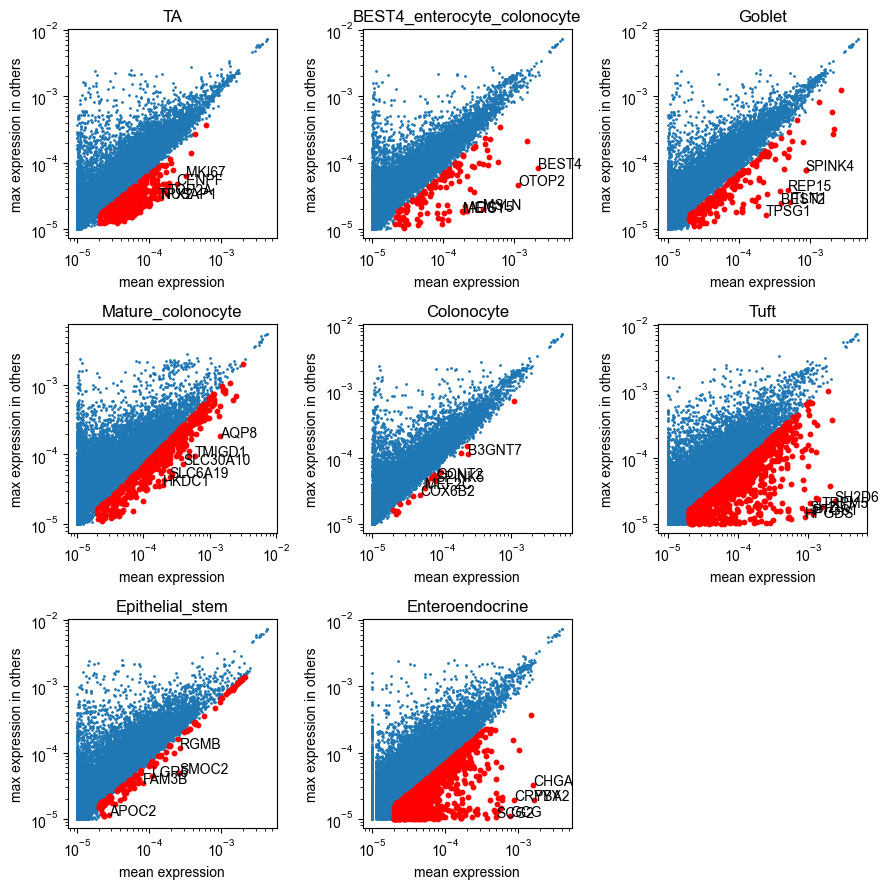

In [21]:
[_, li_markers_dict] = shed_funcs.identify_marker_genes(li_sig_mat, min_exp=1e-5, min_fc=1.5, pn=1e-5)

In [22]:
# sum all li_markers_dict
li_markers = []
for cell_type in li_markers_dict.keys():
    li_markers += list(li_markers_dict[cell_type])
li_markers = list(set(li_markers))
print("number of markers: ", str(len(li_markers)))

number of markers:  3948


In [23]:
intersect_markers = np.intersect1d(np.intersect1d(li_markers, li_adata.var_names), organs_markers_dict['Large_Intestine'])

In [24]:
# for each marker - show the fraction within wash, biopsy and serum
li_adata[:,intersect_markers]

View of AnnData object with n_obs × n_vars = 146 × 58
    obs: 'Run', 'AGE', 'Assay Type', 'AvgSpotLen', 'Bases', 'BIOMATERIAL_PROVIDER', 'BioProject', 'BioSample', 'BioSampleModel', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'disease', 'disease_stage', 'Experiment', 'Instrument', 'isolate', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sample_type', 'sex', 'SRA Study', 'tissue', 'location', 'patient', 'disease_str', 'sum_of_umis', 'batch'
    var: 'gene_name-1'
    layers: 'counts', 'mat_norm', 'log_norm', 'log_zscore'

Correlation: 0.18654702267786447, p-value: 0.16088085198624172


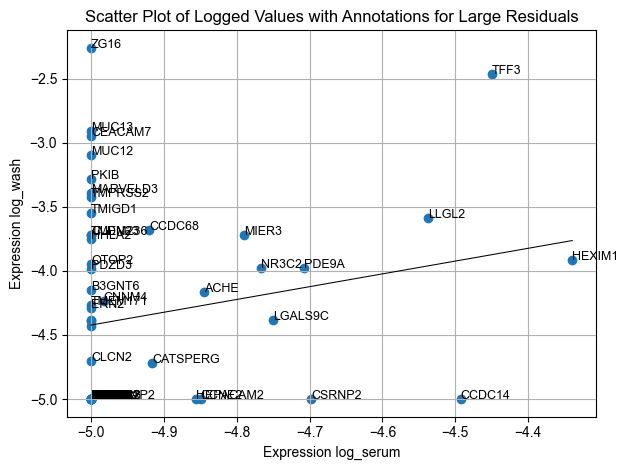

In [34]:
colon_hc = shed_funcs.calc_resids_by_field(li_adata[:,intersect_markers], "sample_type", "serum", "wash", RESID_THRESH=0.1, layer='mat_norm')
colon_hc['gene_display'] = colon_hc.index

In [35]:
# add cell of origin to each marker gene
colon_hc['cell_of_origin'] = "NA"
for cell_type in li_markers_dict.keys():
    print(cell_type)
    for gene in li_markers_dict[cell_type]:
        if gene in colon_hc.index:
            colon_hc.loc[gene, 'cell_of_origin'] = cell_type
colon_hc.head(5)

TA
BEST4_enterocyte_colonocyte
Goblet
Mature_colonocyte
Colonocyte
Tuft
Epithelial_stem
Enteroendocrine


,serum,wash,log_serum,log_wash,residual,gene_display,cell_of_origin
gene_name,,,,,,,
ACHE,0.000004,0.000058,-4.844593,-4.165608,0.101599,ACHE,Mature_colonocyte
ANKRD20A4,0.000000,0.000031,-5.000000,-4.385991,0.036465,ANKRD20A4,Mature_colonocyte
ATOH1,0.000000,0.000000,-5.000000,-5.000000,-0.577544,ATOH1,Goblet
B3GNT6,0.000000,0.000061,-5.000000,-4.146035,0.276421,B3GNT6,Goblet
BEST2,0.000000,0.000000,-5.000000,-5.000000,-0.577544,BEST2,Goblet


In [54]:
y_lim

(-5.137046010622703, -2.1220337769232365)

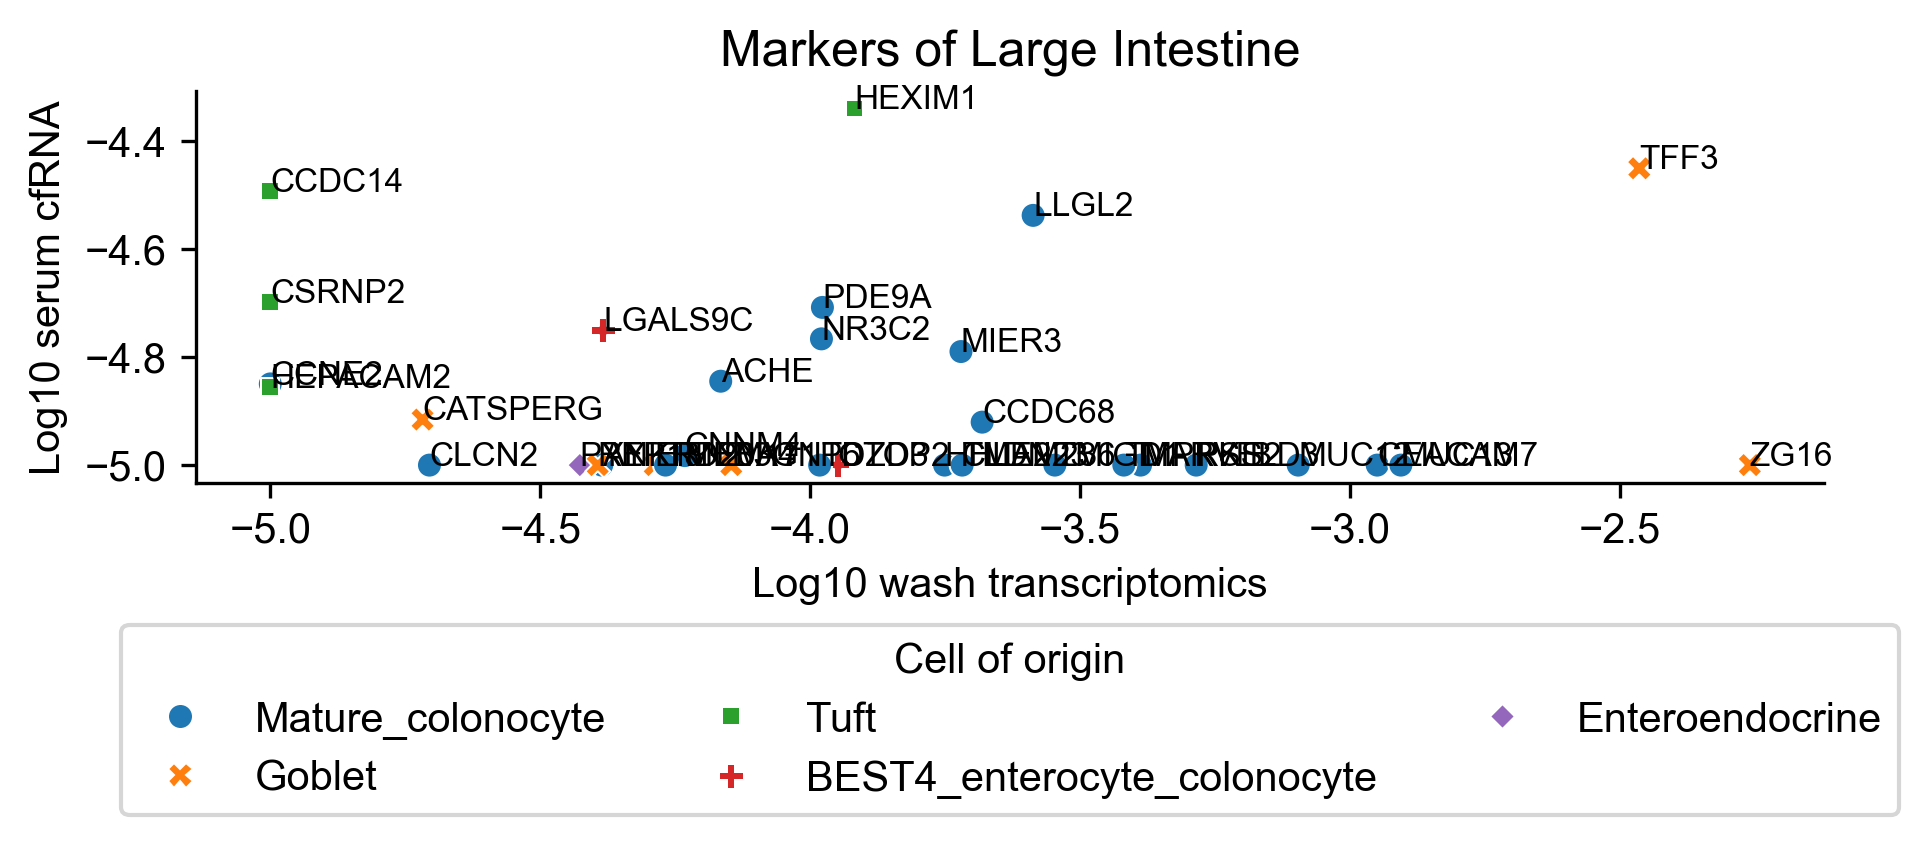

In [63]:
fig,ax = plt.subplots(figsize=(7, 5), dpi=300)
# select genes with serum or wash >0
colon_hc = colon_hc[(colon_hc['serum'] > 0) | (colon_hc['wash'] > 0)].copy() 
sns.scatterplot(data=colon_hc, x='log_wash', y='log_serum', hue='cell_of_origin', style='cell_of_origin', alpha=1,ax=ax)

# save legend
legend = plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.9), title="Cell of origin", ncol=3)
# get legend handles and labels
handles, labels = legend.get_patches(), [text.get_text() for text in legend.get_texts()]
# create dictionary of handles colors
handles_colors = {label: matplotlib.colors.to_hex(handle.get_facecolor()[0]) for label, handle in zip(labels, handles)}

# map colors to cell types
colon_hc['cell_color'] = colon_hc['cell_of_origin'].map(handles_colors)

# add gene names to the plot
texts = [plt.text(colon_hc.iloc[i]['log_wash'], colon_hc.iloc[i]['log_serum'], colon_hc.iloc[i]['gene_display'], fontsize=8) 
         for i in range(len(colon_hc)) 
         if colon_hc.iloc[i]['log_serum'] != colon_hc['log_serum'].min() or colon_hc.iloc[i]['log_wash'] != colon_hc['log_wash'].min()]
# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
# add a line y=x based on axes
# x = np.linspace(min(colon_hc['log_serum']), max(colon_hc['log_serum']), 100)
# y = x
# plt.plot(x, y, color='gray', linestyle='--', linewidth=0.5)
# add x=y label near the line

# make x axis to be same as y axis by getting the limit of yaxis
# y_lim = ax.get_ylim()
# ax.set_xlim(y_lim)

# i want same scale for both axes
ax.set_aspect('equal', adjustable='box')

plt.ylabel("Log10 serum cfRNA")
plt.xlabel("Log10 wash transcriptomics")
plt.title("Markers of Large Intestine")
sns.despine()
plt.show()

# export to pdf
fig.savefig(cfrna_edf_path+"LargeIntestine_markers_cfRNA_wash.pdf",bbox_inches='tight', dpi=300)

In [27]:
# for each marker gene - calculate the fold change between wash and serum
colon_hc['log_fc'] = colon_hc['log_wash'] - colon_hc['log_serum']

In [28]:
# # Create a seaborn barplot for the sorted log_fc values
# sorted_log_fc = colon_hc['log_fc'].sort_values(ascending=True)
# sorted_colors = colon_hc.loc[sorted_log_fc.index, 'cell_color']  # Get colors corresponding to sorted genes

# plt.figure(figsize=(6, 8))
# sns.barplot(x=sorted_log_fc.values, y=sorted_log_fc.index, orient='h', palette=sorted_colors)

# # Add labels and title
# plt.xlabel('Log Fold Change (Wash/Serum)')
# plt.ylabel('Genes')
# plt.title('Colon specific gene expression in wash vs serum')

# plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
# plt.legend(handles=handles, labels=labels, title="Cell of origin")

# plt.tight_layout()
# plt.show()

In [29]:
my_organ = "Large_Intestine"
my_markers = list(organs_markers_dict[my_organ].values)

In [30]:
li_adata

AnnData object with n_obs × n_vars = 146 × 17830
    obs: 'Run', 'AGE', 'Assay Type', 'AvgSpotLen', 'Bases', 'BIOMATERIAL_PROVIDER', 'BioProject', 'BioSample', 'BioSampleModel', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'disease', 'disease_stage', 'Experiment', 'Instrument', 'isolate', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sample_type', 'sex', 'SRA Study', 'tissue', 'location', 'patient', 'disease_str', 'sum_of_umis', 'batch'
    var: 'gene_name-1'
    layers: 'counts', 'mat_norm', 'log_norm', 'log_zscore'

In [31]:
li_adata.obs['log10_sum_of_my_markers'] = list(np.log10(np.ravel(li_adata[:,np.intersect1d(my_markers, li_adata.var_names)].layers['mat_norm'].sum(axis=1))))
li_adata.obs['log10_sum_of_log_norm_my_markers'] = list(np.log10(np.ravel(li_adata[:,np.intersect1d(my_markers, li_adata.var_names)].layers['log_norm'].sum(axis=1))))

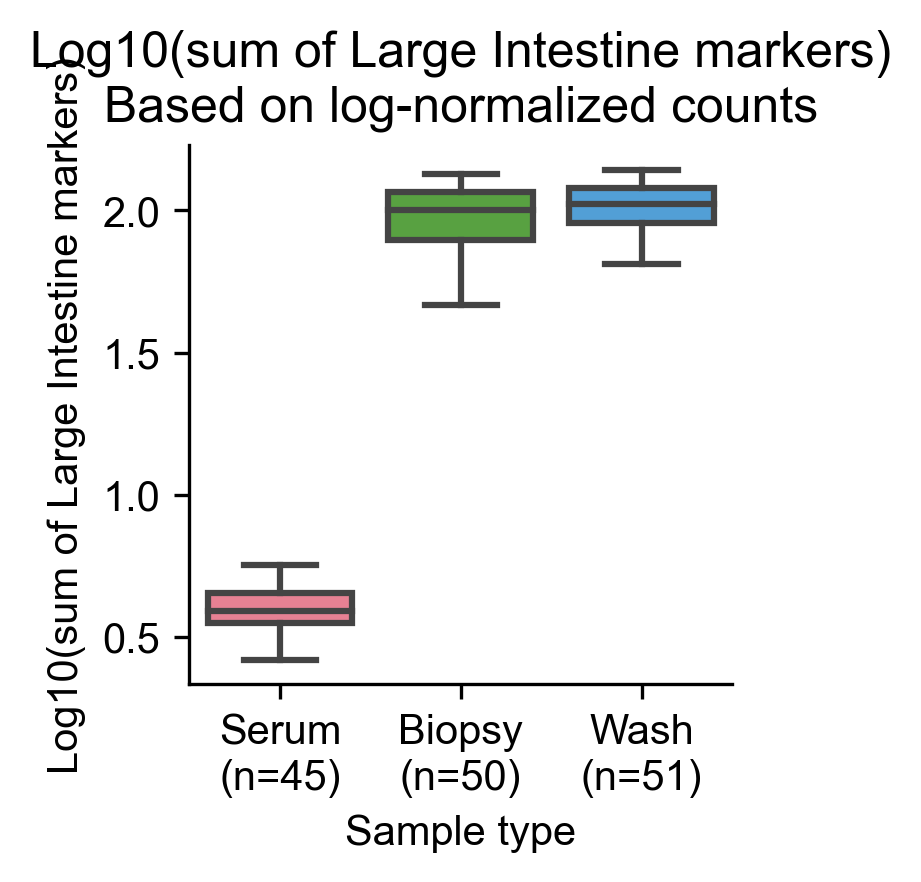

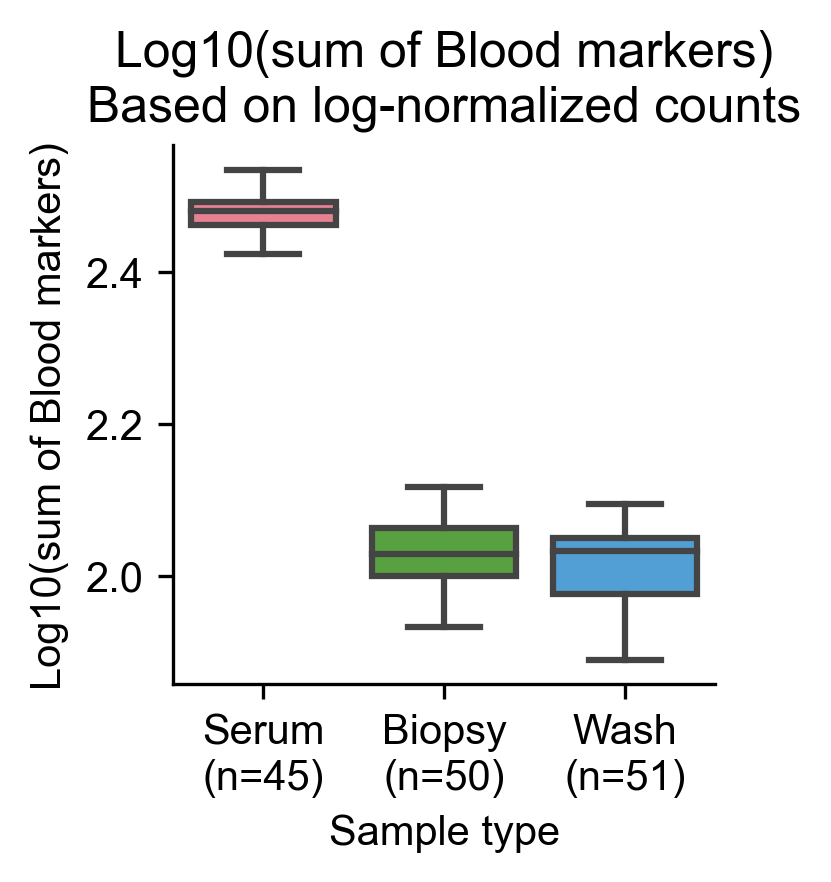

In [32]:
obs_field_to_use = "log10_sum_of_log_norm_my_markers"
start_at_y0 = False

FIG_WIDTH = 7
FIGS_PER_ROW = 3
fig_side = FIG_WIDTH / FIGS_PER_ROW

fig,ax = plt.subplots(figsize=(fig_side, fig_side), dpi=300)
sns.boxplot(data=li_adata.obs, x='sample_type', y=obs_field_to_use, palette="husl",showfliers=False, ax=ax)

# count number of samples per sample type
sample_counts = li_adata.obs['sample_type'].value_counts()

plt.ylabel(f"Log10(sum of {my_organ.replace('_', ' ')} markers)")
plt.title(f"Log10(sum of {my_organ.replace('_', ' ')} markers)\nBased on log-normalized counts")
plt.xlabel("Sample type")
# capitailize xtickslabels
xticks_labels = [label.get_text().capitalize() for label in plt.gca().get_xticklabels()]

# add sample counts to xticks labels
xticks_labels = [f"{label}\n(n={sample_counts[label.lower()]})" for label in xticks_labels]
plt.gca().set_xticklabels(xticks_labels)
# despine
sns.despine()
# get current ylim and start ylim from 0
if start_at_y0:
    ylim = plt.gca().get_ylim()
    plt.gca().set_ylim(0, ylim[1])
plt.show()
# save to pdf
fig.savefig(cfrna_edf_path+"LargeIntestine_cfRNA_Biopsy_Wash.pdf",bbox_inches='tight', dpi=300)



# Negative control
neg_ctrl_organ = "Blood"
neg_ctrl_organ_markers = organs_markers_dict[neg_ctrl_organ]

li_adata.obs['log10_sum_of_log_norm_neg_ctrl_markers'] = list(np.log10(np.ravel(li_adata[:,np.intersect1d(neg_ctrl_organ_markers, li_adata.var_names)].layers['log_norm'].sum(axis=1))))
obs_field_to_use = "log10_sum_of_log_norm_neg_ctrl_markers"

fig,ax = plt.subplots(figsize=(fig_side, fig_side), dpi=300)
sns.boxplot(data=li_adata.obs, x='sample_type', y=obs_field_to_use, palette="husl", showfliers=False, ax=ax)

# count number of samples per sample type
sample_counts = li_adata.obs['sample_type'].value_counts()

# add swarmplot
#sns.swarmplot(data=li_adata.obs, x='sample_type', y=obs_field_to_use, color=".25", alpha=0.5, ax=ax)
plt.ylabel(f"Log10(sum of {neg_ctrl_organ.replace('_', ' ')} markers)")
plt.title(f"Log10(sum of {neg_ctrl_organ.replace('_', ' ')} markers)\nBased on log-normalized counts")
plt.xlabel("Sample type")
# capitailize xtickslabels
xticks_labels = [label.get_text().capitalize() for label in plt.gca().get_xticklabels()]
# add sample counts to xticks labels
xticks_labels = [f"{label}\n(n={sample_counts[label.lower()]})" for label in xticks_labels]
plt.gca().set_xticklabels(xticks_labels)
# get current ylim and start ylim from 0
sns.despine()
if start_at_y0:
    ylim = plt.gca().get_ylim()
    plt.gca().set_ylim(0, ylim[1])
plt.show()
fig.savefig(cfrna_edf_path+neg_ctrl_organ+"_cfRNA_Biopsy_Wash.pdf",bbox_inches='tight', dpi=300)

In [33]:
print(datetime.now())

2025-05-26 17:31:26.275672
